# CS 109B Advanced Topics in Data Science, Final Project, Milestone 4

## Group 9 - Steve Robbins, Chad Tsang, and Ted Heuer
**Harvard University**<br>
**Spring 2017**<br>
**Due Date: ** Wednesday, April 26th, 2017 at 11:59pm

### Milestone 4: Deep learning, due Wednesday, April 26, 2017

For this milestone you will (finally) use deep learning to predict movie genres. You will train one small network from scratch on the posters only, and compare this one to a pre-trained network that you fine tune. [Here](https://keras.io/getting-started/faq/#how-can-i-use-pre-trained-models-in-keras) is a description of how to use pretrained models in Keras.

You can try different architectures, initializations, parameter settings, optimization methods, etc. Be adventurous and explore deep learning! It can be fun to combine the features learned by the deep learning model with a SVM, or incorporate meta data into your deep learning model. 

**Note:** Be mindful of the longer training times for deep models. Not only for training time, but also for the parameter tuning efforts. You need time to develop a feel for the different parameters and which settings work, which normalization you want to use, which model architecture you choose, etc. 

It is great that we have GPUs via AWS to speed up the actual computation time, but you need to be mindful of your AWS credits. The GPU instances are not cheap and can accumulate costs rather quickly. Think about your model first and do some quick dry runs with a larger learning rate or large batch size on your local machine. 

The notebook to submit this week should at least include:

- Complete description of the deep network you trained from scratch, including parameter settings, performance, features learned, etc. 
- Complete description of the pre-trained network that you fine tuned, including parameter settings, performance, features learned, etc. 
- Discussion of the results, how much improvement you gained with fine tuning, etc. 
- Discussion of at least one additional exploratory idea you pursued

In [1]:
#!pip install keras 
#!pip install tensorflow
#!pip install tensorflow.python
#!pip install h5py

In [1]:
from __future__ import print_function
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np
import pandas as pd
from scipy import misc
import time
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras import regularizers

Using TensorFlow backend.


*The following explicit setting of the random seed was not used in testing and tuning efforts, as it would create a propensity to fit a particular dataset.  It was included only to make re-executions of the notebook match the exact text supplied in the analysis.*

In [3]:
import random
random.seed(42)

### Load, split, and prepare the data.

In [4]:
def load_poster_data(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    y_labels = pd.read_csv('y_labels_multiclass.csv')
        
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_id = int(movie[1]['genre_id'].replace('[', '').replace(']',''))
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_id,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [5]:
def stratified_sampler(dataset, observations):
    # Performs a stratified sample on the dataset and returns the number of observations 
    # requested.
    #
    # Parameters:
    #    dataset:  The dataframe to sample, observing class relationships.
    #    observations:  The number of total target observations across all classes.
    #
    # Returns:
    #    A pandas dataframe sampled from the dataset maintaining class relationships.
    class_weights = dataset.groupby("genre_id").agg(['count'])/len(dataset)
    class_sample_counts = class_weights * observations
    class_count = class_weights.shape[0]
    sampled = pd.DataFrame()
    for class_to_sample in class_sample_counts.iterrows():
        class_name = class_to_sample[0]
        desired_class_observations = class_to_sample[1][0]
        sampled_obs = dataset[dataset["genre_id"]==class_name].sample(int(desired_class_observations), replace="True")
        sampled = sampled.append(sampled_obs, ignore_index=True)
    return sampled, class_count

In [6]:
def reshape_and_normalize(data):
    # Reshape the dataset and normalize the 8-bit RGB values to floats.
    image_count = data.shape[0]
    temp = np.ndarray(shape=(image_count, data[0].shape[0], data[0].shape[1], 3))

    for index in range(0, image_count):
        try:
            temp[index] = data[index].reshape(data[0].shape[0], data[0].shape[1], 3)
        except ValueError:
            print(data[index].shape)
    # Since we use relu ubiquitously, normalize to [0,1]
    temp = temp.astype('float32')
    temp /= 255.0

    return temp

In [7]:
def normalize_responses(data):
    # Replace the genre ids to a sequential set from 0..classes
    unique_responses = np.sort(data["genre_id"].unique())
    data["genre_id"] = data["genre_id"].replace(unique_responses, range(0,len(unique_responses)), inplace=False)
    return data

In [8]:
def load_split_prepare_data(train_observations, test_observations, image_size, sample = 'stratified'):
    # Loads, splits, and prepares the data for use by a CNN model.
    #
    # Parameters:
    #    train_observations:  The dataframe to sample, observing class relationships.
    #    test_observations:  The number of total target observations across all classes.
    #    sample:  The sampling method, currently only supports 'stratified'
    #
    # Returns:
    #    The training and testing datasets, with normalized images and categorical responses.
    #    The number of classes.
    posters_data = load_poster_data(image_size)
    posters = normalize_responses(posters_data)
    class_weights = posters.groupby("genre_id").agg(['count'])["movie_id"].to_dict()["count"]
    
    if (sample == 'stratified'):
        train_sample, class_count_train = stratified_sampler(posters, train_observations)
        remaining_posters = posters[~posters["movie_id"].isin(train_sample["movie_id"])]
        test_sample, class_count_test = stratified_sampler(remaining_posters, test_observations)
    else:
        raise('Unsupported sample method : ', sample)
         
    x_train = train_sample["poster"]
    y_train = train_sample["genre_id"]
    x_test = test_sample["poster"]
    y_test = test_sample["genre_id"]

    img_rows = x_train[0].shape[0]
    img_cols = x_train[0].shape[1]
    print('Classes : ', class_count_train)
        
    x_train = reshape_and_normalize(x_train)
    x_test = reshape_and_normalize(x_test)

    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # Convert response to one hot encoding
    y_train = keras.utils.to_categorical(y_train, class_count_train)
    y_test = keras.utils.to_categorical(y_test, class_count_test)

    return (x_train, y_train), (x_test, y_test), class_weights

In [10]:
(x_train, y_train), (x_test, y_test), class_weights = load_split_prepare_data(train_observations = 5000, 
                                                                              test_observations = 1000, 
                                                                              image_size = (138,92), 
                                                                              sample='stratified')
classes = len(class_weights.keys())

Loaded  6824  posters.
Classes :  7
x_train shape: (4996, 138, 92, 3)
4996 train samples
996 test samples


### Baseline (Simple) Multiclass CNN

In [16]:
final_activation_function = 'softmax'

input_activation_function = 'relu'
input_kernel_size = (5,5)
input_shape = (138, 92, 3)
pool_size = (3,3)

hidden_activation_function = 'relu'
hidden_kernel_size = (3,3)

loss_method = 'categorical_crossentropy'
# Learning rate manually tuned based on model performance, too high numerically
# results in nearly no improvement per epoch, and too low numerically doesn't
# cause the weights to change significantly (fine tuning)
optimizer = SGD(lr=0.1, momentum=0.9)
eval_metric = 'accuracy'

# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 512
# number of iterations over the complete training data
epochs = 200

In [12]:
# create an empty network model
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=pool_size))

# Classification layer with Regularizers
model.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function))
model.add(Dropout(0.5))
model.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

In [13]:
debug_flag = 1

In [22]:
def train_evaluate_CNN(x_train, y_train, x_test, y_test, model, batch_size, epochs, verbose, show_layers,
                       validation_split, weights_filename, plot_title, class_weights, augment_data = False):
    # Trains and evaluates the performance numerically and graphically of a compiled Convolutional Neural Net.
    #
    # Parameters:
    #    x_train, y_train:  The predictors and responses of the training set.
    #    x_test, y_test:  The predictors and responses of the test set.
    #    model:  The compiled CNN model.
    #    batch_size:  The batch size used in training.
    #    epochs:  The number of epochs to train.
    #    verbose:  If 1, will display the intermediate epoch training results.
    #    show_layers:  If True, will display the model layers and parameters.
    #    validation_split:  The percentage of the training set to use as a validation set for tuning.
    #    weights_filename:  The name of the file to store the tuned weights in.
    #    plot_title:  The model title to include in the performance plot.
    #    class_weights:  The relative class weights.
    #    augment_data:  If true, will augment the input dataset dramatically increasing size.
    #
    # Returns:
    #    test_accuracy:  The test accuracy (as a float)
    #    train_time:  The time spent training the model, in seconds.
    start_time = time.time()    
    if (augment_data == True):
        datagen = ImageDataGenerator(
            featurewise_center=True,
            samplewise_center=False,
            featurewise_std_normalization=True,
            samplewise_std_normalization=False,
            zca_whitening=False,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False)
        datagen.fit(x_train)
        history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), 
                                      steps_per_epoch=16, 
                                      epochs=epochs,
                                      verbose=verbose)        
    else:
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=verbose,
                            class_weight=class_weights,
                            validation_split = validation_split)
    end_time = time.time()
    train_time = end_time - start_time
    print('Time to train model with ', epochs, ' epochs is : ', train_time, ' seconds.')
    # Evaluate the performance on the testing set.
    score = model.evaluate(x_test, y_test, verbose=verbose)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    if (show_layers == 1):
        print(model.summary())
    
    model.save_weights(weights_filename + '_weights.h5')
    
    plt.plot(history.history['acc'])
    plt.axhline(y=score[1], color='r')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy, " + plot_title);
    print(plt.show())
    
    plt.plot(history.history['val_loss'])
    plt.xlabel("Epoch")
    plt.ylabel("Validation Loss")
    plt.title("Training Accuracy, " + plot_title);
    print(plt.show())
    
    # Return the TEST set accuracy.
    return(score[1], train_time)

In [15]:
experiment_results = pd.DataFrame()

In [18]:
# Test:  Scale class weights
scaled_weights = {0: 1.93229167, 
                  1: 4.31770833, 
                  2: 8.32291667, 3: 8.15625, 4: 7.33854167, 5: 1.0, 6: 4.47395833}
uniform_weights = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1., 5: 1.0, 6: 1.}

Train on 4246 samples, validate on 750 samples
Epoch 1/100
4246/4246 [==============================] - 7s - loss: 1.8109 - acc: 0.2414 - val_loss: 4.2872 - val_acc: 0.0000e+00
Epoch 2/100
4246/4246 [==============================] - 2s - loss: 1.5839 - acc: 0.2605 - val_loss: 4.2008 - val_acc: 0.0000e+00

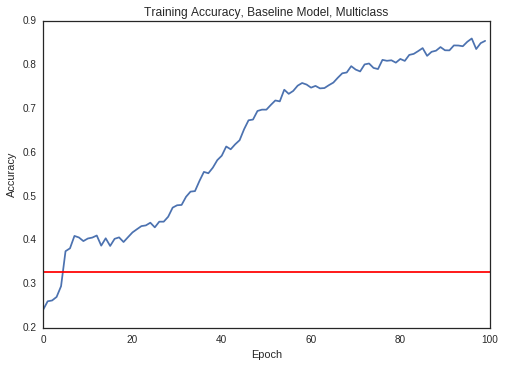

None


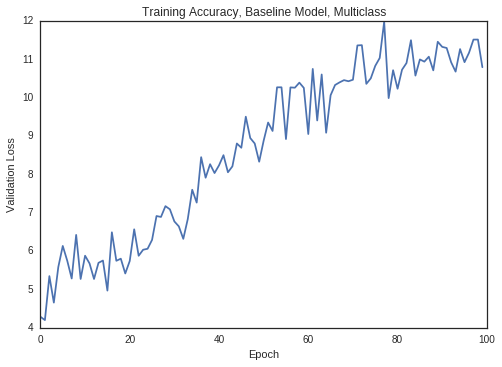

None


In [17]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
experiment = 'Baseline Model, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model, 
                                          batch_size, epochs=100, 
                                          verbose=debug_flag, show_layers=1,
                                          validation_split=0.15, 
                                          weights_filename='baseline',
                                          class_weights=uniform_weights,
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

### Baseline Regularized Multiclass Model

In [18]:
# create an empty network model
model = Sequential()

# Input Layer
model.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=pool_size))

# Classification layer with Regularizers
model.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function, 
                activity_regularizer=regularizers.l1(0.1)))
model.add(Dropout(0.5))
model.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

Train on 3996 samples, validate on 1000 samples
Epoch 1/100
3996/3996 [==============================] - 3s - loss: 906.1696 - acc: 0.2578 - val_loss: 16.9834 - val_acc: 0.0000e+00
Epoch 2/100
3996/3996 [==============================] - 2s - loss: 9.9114 - acc: 0.2953 - val_loss: 21.8222 - val_acc: 0.0000e+00

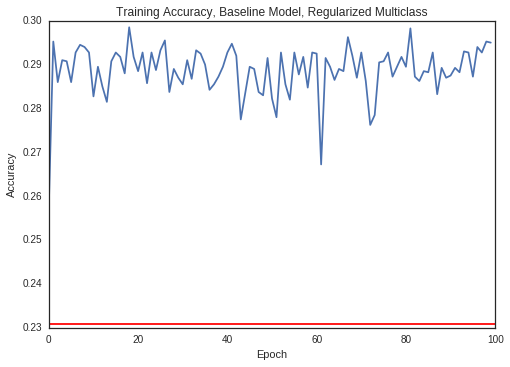

None


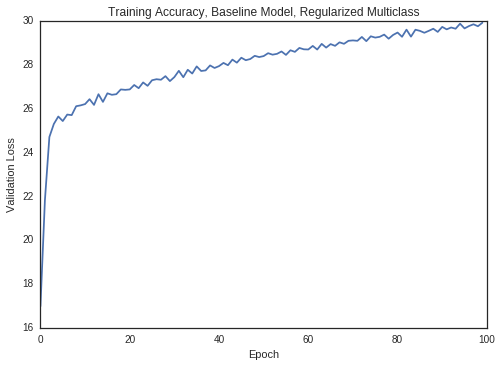

None


In [19]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
experiment = 'Baseline Model, Regularized Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model, 
                                          batch_size, epochs=100, 
                                          verbose=debug_flag, show_layers=1,
                                          validation_split=0.2, 
                                          weights_filename='baseline_reg',
                                          class_weights=scaled_weights,
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

### Baseline (Simple) Model with Data Augmentation

In [20]:
# Recreate the same model (to start "fresh") for using augmented dataset.
# create an empty network model
model_aug = Sequential()

# Input Layer
model_aug.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model_aug.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model_aug.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model_aug.add(Dropout(0.25))
model_aug.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model_aug.add(Flatten())
model.add(Dense(64, activation=hidden_activation_function, 
                activity_regularizer=regularizers.l1(0.1)))
model_aug.add(Dropout(0.5))
model_aug.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model_aug.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

Epoch 1/200
16/16 [==============================] - 17s - loss: 2.8000 - acc: 0.1940     

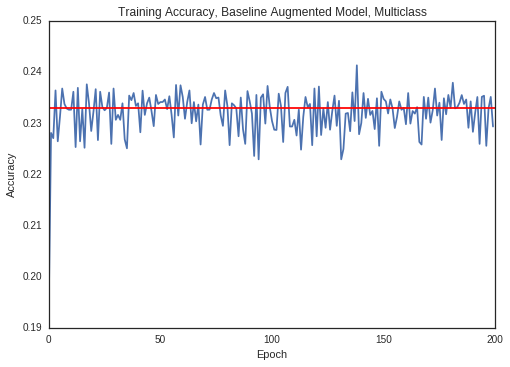

None


In [21]:
# The actual training of the CNN using the parameters and model previously specified.
# The validation set is a split of the stratified sampled training data.
experiment = 'Baseline Augmented Model, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_aug, 
                                          batch_size, epochs=200, 
                                          verbose=debug_flag, 
                                          show_layers=1,
                                          validation_split=0.20, 
                                          weights_filename='baseline_aug', 
                                          plot_title=experiment,
                                          class_weights = scaled_weights,
                                          augment_data = True)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

### Baseline Model with Additional Layer

In [22]:
# create an empty network model
model2 = Sequential()

# Input Layer
model2.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model2.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model2.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

model2.add(Conv2D(48, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model2.add(Dropout(0.25))
model2.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model2.add(Flatten())
model2.add(Dense(64, activation=hidden_activation_function))
model2.add(Dropout(0.5))
model2.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model2.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

Train on 4246 samples, validate on 750 samples
Epoch 1/200
4246/4246 [==============================] - 3s - loss: 36.1881 - acc: 0.2602 - val_loss: 13.6715 - val_acc: 0.0000e+00
Epoch 2/200
4246/4246 [==============================] - 2s - loss: 11.3137 - acc: 0.2574 - val_loss: 18.7470 - val_acc: 0.0000e+00

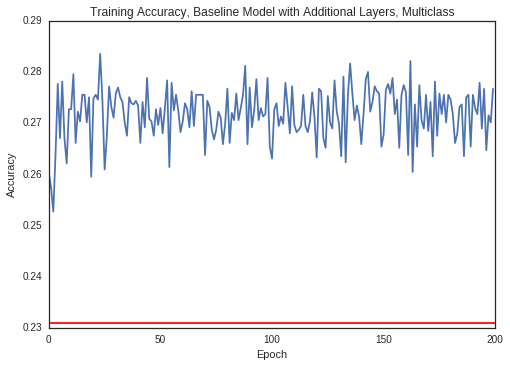

None


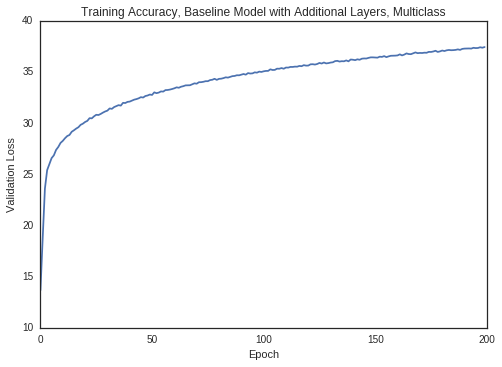

None


In [23]:
# The actual training of the CNN using the parameters and model previously specified.
experiment = 'Baseline Model with Additional Layers, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model2, 
                                          batch_size, epochs=200, 
                                          verbose=debug_flag, show_layers=True,
                                          validation_split=0.15, 
                                          weights_filename='baseline_addl_layer', 
                                          class_weights=scaled_weights,
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

### Tune an existing CNN (Multi-class)

The following code is used with modification from the sample InceptionV3 code from the Keras documentation, https://keras.io/applications/

In [24]:
# Create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer 
predictions = Dense(classes, activation=final_activation_function)(x)

# this is the model we will train
model_tune = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_tune.compile(optimizer='rmsprop', loss=loss_method,  metrics=[eval_metric])

Train on 3996 samples, validate on 1000 samples
Epoch 1/10
3996/3996 [==============================] - 18s - loss: 25.9208 - acc: 0.2803 - val_loss: 53.4514 - val_acc: 1.0000e-03
Epoch 2/10
3996/3996 [==============================] - 7s - loss: 11.7539 - acc: 0.3418 - val_loss: 62.3071 - val_acc: 0.0000e+00

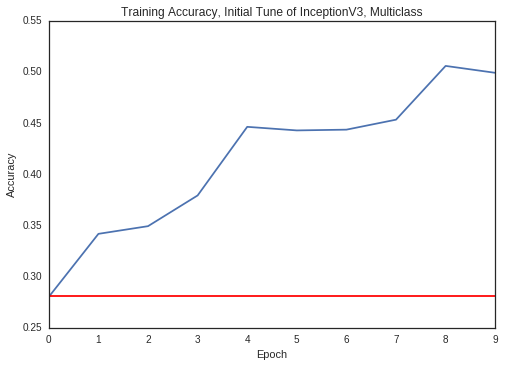

None


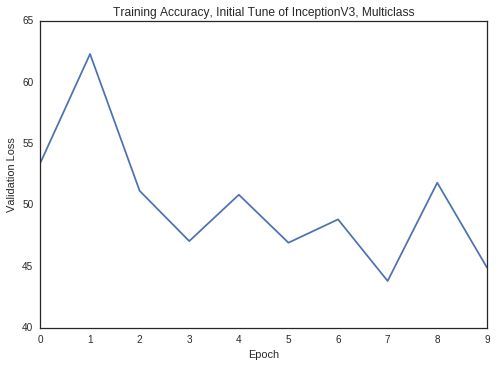

None


In [25]:
# train the model on the new data for a few epochs
# fine-tune the model
experiment = 'Initial Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_tune, 
                                          batch_size, epochs=10, 
                                          verbose=debug_flag, show_layers=True,
                                          validation_split=0.20, 
                                          weights_filename='inceptionv3_initial', 
                                          class_weights=scaled_weights,
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

In [26]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:172]:
   layer.trainable = False
for layer in model.layers[172:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.8), loss=loss_method,  metrics=[eval_metric])

0 input_1
1 conv2d_10
2 batch_normalization_1
3 activation_1
4 conv2d_11
5 batch_normalization_2
6 activation_2
7 conv2d_12
8 batch_normalization_3
9 activation_3
10 max_pooling2d_10
11 conv2d_13
12 batch_normalization_4
13 activation_4
14 conv2d_14
15 batch_normalization_5
16 activation_5
17 max_pooling2d_11
18 conv2d_18
19 batch_normalization_9
20 activation_9
21 conv2d_16
22 conv2d_19
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_15
29 conv2d_17
30 conv2d_20
31 conv2d_21
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_25
42 batch_normalization_16
43 activation_16
44 conv2d_23
45 conv2d_26
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_22
52 conv2d_24
53 conv2d_27
54 conv2d_28
55 batch_normalization_13
56 

Train on 3996 samples, validate on 1000 samples
Epoch 1/200
3996/3996 [==============================] - 8s - loss: 7.9260 - acc: 0.5210 - val_loss: 45.3977 - val_acc: 0.0020
Epoch 2/200
3996/3996 [==============================] - 7s - loss: 7.1913 - acc: 0.5265 - val_loss: 45.3103 - val_acc: 0.0080

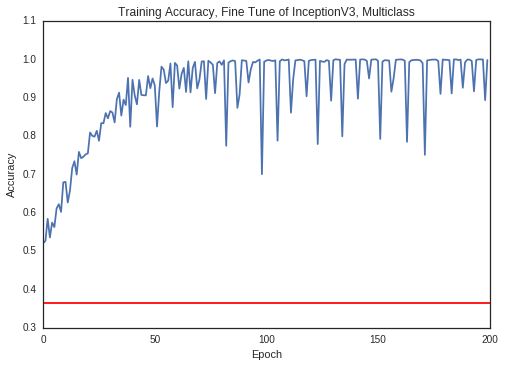

None


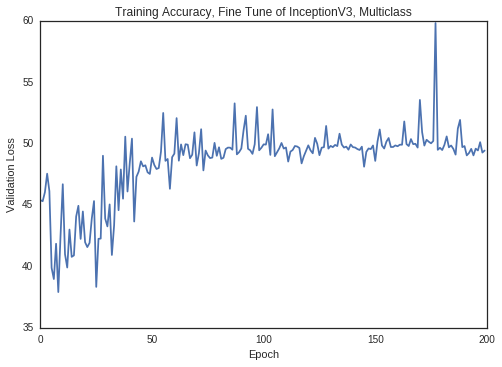

None


In [27]:
# Fine tune the new model, using the "fine" parameters of SGD previously defined.
experiment = 'Fine Tune of InceptionV3, Multiclass'
accuracy, train_time = train_evaluate_CNN(x_train, y_train, x_test, y_test, model_tune, 
                                          batch_size, epochs=200, 
                                          verbose=debug_flag, show_layers=False,
                                          validation_split=0.20, 
                                          weights_filename='inceptionv3_finetune', 
                                          class_weights=scaled_weights,
                                          plot_title=experiment)
experiment_results = experiment_results.append({'Name' : experiment, 
                                                'Test Accuracy' : accuracy, 
                                                'Train Time': train_time}, ignore_index=True)

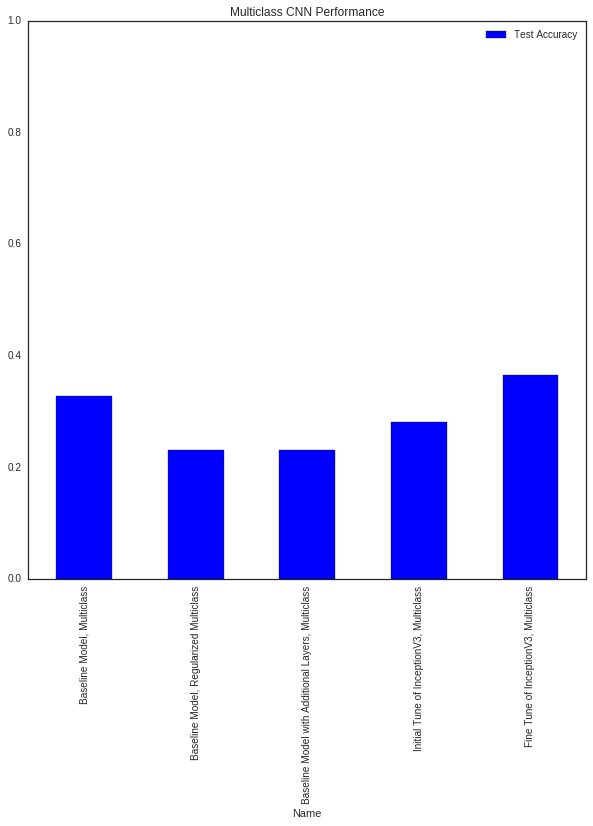

In [28]:
experiment_results.plot(x='Name', y='Test Accuracy', kind='bar', 
                        title='Multiclass CNN Performance', ylim=(0,1.0), figsize=(10,10));

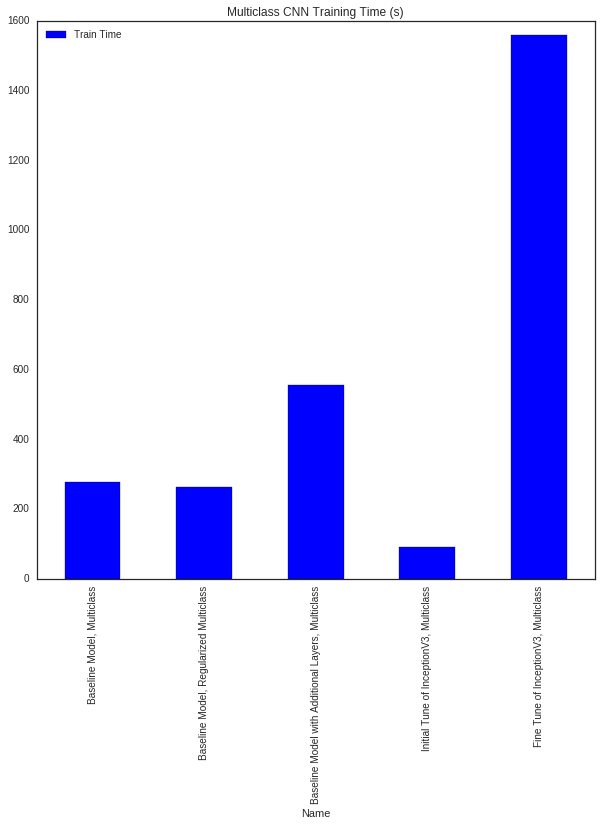

In [29]:
experiment_results.plot(x='Name', y='Train Time', kind='bar', 
                        title='Multiclass CNN Training Time (s)', figsize=(10,10));

### Tuning Explored and Results Commentary

From the above results, we see that the baseline model without regularization nor class weighting steadily increased training accuracy per epoch, culminating to a peak of ~85%, however the validation loss function was increasing, indicating that the model is likely overfitting the training data.  The accuracy on unseen test data (1000 movie posters) resulted in an accuracy of 32.7%.  The parameters used were 100 epochs, with 15% of the 4000 stratified sample observations of training data used as validation, stochastic gradient descent with a learning rate of 0.1, relu activation functions and a final activation function of 'softmax'.  Although dropout layers were employed to reduce overfitting, the model (based upon the shape of the validation loss) appears to have been overfitting, therefore the next experiment introduced regularization into the same model.

The next model employed regularization to the final activiation function and class weights, but otherwise unchanged from the previous model.  The learning rate (slope of the training accuracy) seemed to oscillate about 0.29 (potential causes will be explained in the tuning section, below), indicating the model did not appear to be significantly learning.  Futher exacerbating the results, the validation set loss metric was increasing across epochs, whereas one would hope that it would decrease over epochs.  The resultant accuracy on the same unseen test set was only 23%, marginally better than a random guess of 1/classes = 14.3%.  

The next model (not included in the performance summary plots) added synthetic data generation to the previous.  This resulted in a significant reduction in training speed with an accuracy of 23%, indicating that the sampling and transformations of the original dataset did not improve the accuracy of the trained model.  Given the simplicity (few layers) of the models explored so far, it was chosen to add more layers into the model for the next experiment.

The third model in the performance summary is identical to the second, with the addition of another trio of convolution, dropout and pooling layers within the hidden model.  This resulted in no increase in test set accuracy at ~23%.  This set of bespoke models, although out performing random guesses, is perhaps too simple to capture the information in the posters.  As such, the next two models leverage a pre-trained CNN model with hundreds of layers.

The fourth model is the execution of the Keras Inception V3 model, with a few layers added and all of the Inception V3 weights frozen for 10 epochs.  The intent of this was to quicly train the added layers.  This resulted in a test set accuracy of 28% over just the 10 epochs, with a very quick learning rate.

The fifth model is the fine tune of the fourth model, using stocastic gradient descent with a very small learning rate (0.0001) and a momentum value of 0.8, trained across 200 epochs.  The validation loss plot indicates that the loss was slightly decreasing after an initial rise, and the training accuracy plot is evidence of overfitting, evidenced by the extremely high training accuracy (over 99% for many epochs) and the occasional dramatic increase in loss/drop in accuracy for some epochs, especially considering the low learning rate (and thus very small changes in the weights).  Fortunately, the accuracy of this model on the unseen test set exceeded 36%, compared to the random baseline of 14.3%.

#### But, is 36% accuracy "good"?

Given the datasets in previous assignments have been carefully prepared for pedagogical value, it is tempting to be accustomed to accuracies above 0.90.  As such, 36% accuracy seems low at first impression.  To convince myself in regard to the performance, a few reference points are:
- **Random Class Prediction** - Random class prediction with 7 classes would result in an accuracy of 1/7=14.3%
- **Predominant Class Prediction** - The predominant class prediction (maximum class weight / sum of the weights) is 8.32292 / 35.54167 = 23.42%.
- **"Expert Prediction** - I randomly examined 20 movie posters and set of genres used, using all of my *a priori* knowledge and ability to read the text, and attempted to "expertly" classify the posters.  I was able to correctly classify 8 of the 20 posters, thus I had an accuracy of 40% (albeit with a small sample).  
- **Milestone 3 Investigation** - For milestone three, we incorporated average color (R, G, and B) into our traditional models and PAL intensities, in addition to other metadata about the movies.  These models in the multiclass setting achieved 32.3% for Random Forest and 26.4% for a Support Vector Machine with an RBF kernel.

As such, the accuracy achieved by the CNN is rather impressive, as it is similar to mine and exceeds the random sampling, however is only looking at the color and structural elements (such as edges and shapes).  It is obvious that this is a real-world problem, and a quite challenging one at that.

#### Tuning Observations

This notebook has been executed hundreds of times with varying parameters using approximately 50 hours of Tesla K80 GPU time, attempting to develop an intuition about the parameters.  The following is the result of this developed intuition:
- **Adding Layers** - The addition of layers increases the flexibility of the model, allowing it to learn quicker on the training set at the expense of additional computation time.  Unfortunatley, without regularization it dramatically increases the chances of overfitting. 
- **Epochs** - The models have been executed with between 10 and 500 epochs, however most of the models explored seem to plateau within 100 epochs.  As such, most of the epochs have been set to 200.
- **Regularization** - Regularization was employed both with l1 and l2 regularization to the activation function and with dropout, which effectively performs implicit regularization by dropping data.  Regularization proved to be very tricky to tune, as insufficient (or absent) regularization led to rapid overfitting on flexible models, whereas "over-regularization" resulted in models plateauing at very low training accuracies.
- **Learning Rate** - Learning rate (and method, SGD & rmsprop) impacted the slope of the learning rate, although too high of a learning rate resulted in instability, too low resulted in very fine tuning and very low learning rates.  It became quite obvious that a relatively high learning rate, such as 0.1 with SGD, followed by iterative reduction in the rate performed well, such as the Inception V3 training.
- **Synthetic Data Generation** - Synethetic data generation was explored using the Keras ImageDataGenerator, creating images via cropping, roations, flips and various transformations to the original dataset.  This significantly increased run time, and given the relatively large amount of data available, did not prove to be worthwhile for this dataset given the constraints.
- **Class Weights** - Strangely, the use of class weights, representing the class proportions, did not *appear* to improve the accuracy of the model, possibly due to the use of stratified (class-proportionate) sampling of the training data.  
- **Validation Splits** - Adjusting the validation splits from 15-30% had the anticipated effect on the training, with reductions in training data (due to a higher validation percentage) reducing the learning rate.
- **Drop Out Percentage** - The percentage of dropout, varying between 25% and 50% on layers, impacted both the learning rate and seemed to slightly reduce overfitting concerns.

### Next Steps
As a follow-on from Milestone 3, we discovered that a multi-label approach generated more intuitive results than our multiclass with the classes being reduced using heuristics.  We intend on creating a compositite stacking model for our final predictive model, with multi-label class probabilities being derived from the posters, but also intermediate data via other means, such as textaul analysis of the movie overviews and other metadata.  As such, the next steps will be to train a multi-label model based upon the posters and generate and save the label probabilities as input to the final model, as follow.

### Create the Convolutional Neural Net architecture, from scratch (Multi-label)

In [9]:
def load_poster_data_multilabel(image_size, source_size = 'w92', verbose = False):
    # Loads the poster image data at the requested size, the assigned genre, and the movie id.
    #
    y_labels = pd.read_csv('y_labels_multilabel.csv')
        
    image_path = './posters/' + source_size + '/'
    posters = pd.DataFrame()
    for movie in y_labels.iterrows():
        row = movie[0]
        movie_id = movie[1]['movie_id']
        genre_ids = movie[1]['genre_id'].replace('[', '').replace(']','').split(',')
        try:
            image = misc.imread(image_path + str(movie_id) + '.jpg')
            image_resize = img_to_array(misc.imresize(image, image_size))
            if (image_resize.shape[2]==3):
                posters = posters.append({'movie_id' : movie_id, 
                                          'genre_id' : genre_ids,
                                          'poster' : image_resize}, ignore_index = True)
        except IOError:
            if (verbose == True):
                print('Unable to load poster for movie #', movie_id)
    print('Loaded ', posters.shape[0], ' posters.')
    return posters

In [10]:
temp = load_poster_data_multilabel((138,92), 'w92', False)

Loaded  6824  posters.


In [12]:
train_sample = temp.sample(5000, replace="False")
test_sample = temp.sample(1000, replace="False")

train_posters = train_sample["poster"]
test_posters = test_sample["poster"]

x_train = reshape_and_normalize(train_posters.as_matrix())
x_test = reshape_and_normalize(test_posters.as_matrix())


img_rows = x_train[0].shape[0]
img_cols = x_train[0].shape[1]

y_train = train_sample["genre_id"]
y_test = test_sample["genre_id"]

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (5000, 138, 92, 3)
5000 train samples
1000 test samples


In [13]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(y_train)
y_test = mlb.transform(y_test)
classes = max(y_train.shape[1], y_test.shape[1])

In [14]:
loss_method='binary_crossentropy'
final_activation_function = 'sigmoid'

In [17]:
# create an empty network model
model_ml = Sequential()

# Input Layer
model_ml.add(Conv2D(16, kernel_size=input_kernel_size, activation=input_activation_function, input_shape=input_shape))
model_ml.add(MaxPooling2D(pool_size=pool_size))

# Hidden Layer(s)
model_ml.add(Conv2D(32, kernel_size=hidden_kernel_size, activation=hidden_activation_function))
model_ml.add(Dropout(0.25))
model_ml.add(MaxPooling2D(pool_size=pool_size))

# Classification layer
model_ml.add(Flatten())
model_ml.add(Dense(64, activation=hidden_activation_function))
model_ml.add(Dropout(0.5))
model_ml.add(Dense(classes, activation=final_activation_function))

# Compile the model.
model_ml.compile(loss=loss_method, optimizer=optimizer, metrics=[eval_metric])

In [19]:
test_genre_probabilities = np.array(model_ml.predict_proba(x_test))

In [ ]:
# We may wish to consider tuning an InceptionV3 or other pre-trained model for better results.

### References Used
https://keras.io/callbacks/

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://keras.io/getting-started/faq/#how-can-i-use-keras-with-datasets-that-dont-fit-in-memory

https://elitedatascience.com/keras-tutorial-deep-learning-in-python#step-4

http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/